## 50.データの入手・整形

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import csv
import os
from common_utils import make_csv

# その他
import warnings

In [2]:
# configs
CSV_PATH = './ch6_folder/NewsAggregatorDataset/newsCorpora.csv'
NAMES = ('TITLE', 'URL','PUBLISHER', 'CATEGORY','STORY', 'HOSTNAME', 'TIMESTAMP')
PUBLISHERS = ['Reuters', 'Huffington Post','Businessweek', 'Contactmusic.com', 'Daily Mail']
DATA_PATH = './ch6_folder/save_data/'
HEADERS = ['CATEGORY', 'TITLE']

Warningを消すために以下のコードを追加します。

In [3]:
warnings.simplefilter('ignore')

In [4]:
df = pd.read_table(CSV_PATH, names=NAMES)

In [5]:
data_df = df[df['PUBLISHER'].isin(PUBLISHERS)]

In [6]:
data_list = np.array(data_df[HEADERS]).tolist()

In [7]:
train_data , test_and_valid_data = train_test_split(data_list, test_size=0.2, random_state=123)

In [8]:
valid_data = test_and_valid_data[:(len(test_and_valid_data)//2)]
test_data = test_and_valid_data[(len(test_and_valid_data)//2):]

In [9]:
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

In [10]:
make_csv(DATA_PATH + 'train.csv', train_data,HEADERS)
make_csv(DATA_PATH + 'valid.csv', valid_data,HEADERS)
make_csv(DATA_PATH + 'test.csv', test_data,HEADERS)

./ch6_folder/save_data/train.csvはもう存在しています
./ch6_folder/save_data/valid.csvはもう存在しています
./ch6_folder/save_data/test.csvはもう存在しています


## 特徴量抽出 & 学習

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [12]:
# configs
TRAIN_CSV_PATH = './ch6_folder/save_data/train.csv'
VALID_CSV_PATH = './ch6_folder/save_data/valid.csv'
TEST_CSV_PATH = './ch6_folder/save_data/test.csv'

In [13]:
CATEGORY_TAG = {'b': 0, 't': 1, 'e': 2, 'm': 3}

In [14]:
train_titles = pd.read_csv(TRAIN_CSV_PATH)['TITLE'].tolist()
valid_titles = pd.read_csv(VALID_CSV_PATH)['TITLE'].tolist()
test_titles = pd.read_csv(TEST_CSV_PATH)['TITLE'].tolist()

In [15]:
all_titles = train_titles + valid_titles + test_titles

In [16]:
vectrizer = CountVectorizer()
X = vectrizer.fit_transform(all_titles)

In [17]:
X.shape

(13340, 13577)

In [18]:
type(X)

scipy.sparse.csr.csr_matrix

In [19]:
X = np.array(X.todense())

In [20]:
y_train= pd.read_csv(TRAIN_CSV_PATH)['CATEGORY'].map(CATEGORY_TAG).tolist()
y_valid = pd.read_csv(VALID_CSV_PATH)['CATEGORY'].map(CATEGORY_TAG).tolist()
y_test = pd.read_csv(TEST_CSV_PATH)['CATEGORY'].map(CATEGORY_TAG).tolist()

In [21]:
X_train = X[:len(y_train)]
X_valid = X[len(y_train):(len(y_train)+len(y_valid))]
X_test = X[(len(y_train)+len(y_valid)):]

In [22]:
lr = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## 予測と正解率の計測、混同行列の作成

In [23]:
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
y_predict = lr.predict(X_test)

In [25]:
cm = confusion_matrix(y_predict, y_test)

In [26]:
cm

array([[531,  10,   3,   8],
       [ 14, 127,   1,   1],
       [ 12,  10, 508,   6],
       [  2,   0,   1, 100]])

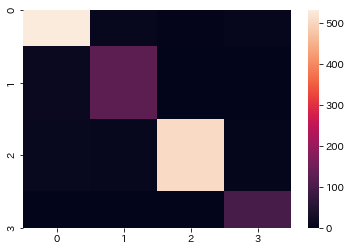

In [27]:
sns.heatmap(cm)

## 適合率、再現率、F1スコアの計測

ロジスティック回帰モデルの適合率、再現率、F1スコアはいかのようになっている。

In [28]:
all_acc_score = accuracy_score(y_predict, y_test)
all_precision_score = precision_score(y_predict, y_test, average='macro')
all_recall_score = recall_score(y_predict, y_test, average='macro')
all_f1_score = f1_score(y_predict, y_test, average='macro')
print(all_acc_score, all_precision_score, all_recall_score, all_recall_score, all_f1_score)

0.9490254872563718 0.9184186903725892 0.9421758475721591 0.9421758475721591 0.9294325798124617


In [29]:
business_predict = [y_predict[i] for i in range(len(y_test)) if y_test[i] == 0]
technology_predict = [y_predict[i] for i in range(len(y_test)) if y_test[i] == 1]
entertainment_predict = [y_predict[i] for i in range(len(y_test)) if y_test[i] == 2]
health_predict = [y_predict[i] for i in range(len(y_test)) if y_test[i] == 3]

bisinessにかんする適合率、再現率、F1スコアは以下のようになっている。

In [30]:
business_acc_score = accuracy_score(business_predict, [0]*len(business_predict))
business_precision_score = precision_score(business_predict, [0]*len(business_predict), average='macro')
business_recall_score = recall_score(business_predict, [0]*len(business_predict), average='macro')
business_f1_score = f1_score(business_predict, [0]*len(business_predict), average='macro')
print(business_acc_score, business_precision_score, business_recall_score, business_f1_score)

0.9499105545617174 0.23747763864042934 0.25 0.24357798165137615


technologyに関する適合率、再現率、F1スコアは以下のようになっている。

In [31]:
technology_acc_score = accuracy_score(technology_predict, [1]*len(technology_predict))
technology_precision_score = precision_score(technology_predict, [1]*len(technology_predict), average='macro')
technology_recall_score = recall_score(technology_predict, [1]*len(technology_predict), average='macro')
technology_f1_score = f1_score(technology_predict, [1]*len(technology_predict), average='macro')
print(technology_acc_score, technology_precision_score, technology_recall_score, technology_f1_score)

0.8639455782312925 0.2879818594104308 0.3333333333333333 0.30900243309002434


entertainmentに関する適合率、再現率、F1スコアは以下のようになっている。

In [32]:
entertainment_acc_score = accuracy_score(entertainment_predict, [2]*len(entertainment_predict))
entertainment_precision_score = precision_score(entertainment_predict, [2]*len(entertainment_predict), average='macro')
entertainment_recall_score = recall_score(entertainment_predict, [2]*len(entertainment_predict), average='macro')
entertainment_f1_score = f1_score(entertainment_predict, [2]*len(entertainment_predict), average='macro')
print(entertainment_acc_score, entertainment_precision_score, entertainment_recall_score, entertainment_f1_score)

0.9902534113060428 0.2475633528265107 0.25 0.24877571008814886


healthに関する適合率、再現率、F1スコアは以下のようになっている。

In [33]:
health_acc_score = accuracy_score(health_predict, [3]*len(health_predict))
health_precision_score = precision_score(health_predict, [3]*len(health_predict), average='macro')
health_recall_score = recall_score(health_predict, [3]*len(health_predict), average='macro')
health_f1_score = f1_score(health_predict, [3]*len(health_predict), average='macro')
print(health_acc_score, health_precision_score, health_recall_score, health_f1_score)

0.8695652173913043 0.21739130434782608 0.25 0.23255813953488372


## 特徴量の重みの確認

In [34]:
id2names = vectrizer.vocabulary_
sorted_by_value_id2names = {}
for k, v in sorted(id2names.items(), key=lambda x: x[1]):
    sorted_by_value_id2names[k] = v

In [35]:
columns = list(sorted_by_value_id2names.keys())

In [36]:
weight_df = pd.DataFrame(lr.coef_)
weight_df.index = ['b', 't', 'e', 'm']
weight_df.columns = columns

In [37]:
top10_toku = weight_df.T.sort_values(by=['b', 't', 'e', 'm'], ascending=False)[:10].index

In [38]:
dobe10_toku = weight_df.T.sort_values(by=['b', 't', 'e', 'm'], ascending=True)[:10].index

In [39]:
dobe10_toku

Index(['activision', 'ebola', 'aereo', 'nintendo', 'twitch', 'kardashian',
       'paul', 'cap', 'subscription', 'star'],
      dtype='object')

In [40]:
top10_toku

Index(['ecb', 'bank', 'fitch', 'yellen', 'lobster', 'argentina', 'piketty',
       'fracking', 'hillary', 'fed'],
      dtype='object')

## 正則化パラメータの変更

In [41]:
C_list = [0.2, 0.4, 0.6, 0.8, 1.0]

In [42]:
acc_list=[]
for c in C_list:
    lr1 = LogisticRegression(C=c, penalty='l1', solver='liblinear')
    lr1.fit(X_train, y_train)
    y1_predict = lr1.predict(X_test)
    acc_score = accuracy_score(y1_predict,y_test)
    acc_list.append(acc_score)

In [43]:
acc_list

[0.8380809595202399,
 0.8898050974512743,
 0.9152923538230885,
 0.9347826086956522,
 0.9490254872563718]

## ハイパーパラメータの探索

In [44]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [45]:
type(X_train)

numpy.ndarray

In [46]:
X_train_and_valid = np.vstack((X_train, X_valid))

In [47]:
y_train_and_valid = y_train + y_valid

In [48]:
test_fold = [-1 for i in range(len(X_train))]+ [1 for i in range(len(X_train),len(X_train_and_valid))]

In [49]:
ps = PredefinedSplit(test_fold)

In [50]:
params = {'penalty':['l1','l2'],
          'C':[0.5,1.0,2.0,10.0],
          'solver':['liblinear']
         }

In [51]:
lr = LogisticRegression(multi_class='auto')
clf = GridSearchCV(lr, param_grid=params, cv = ps)

In [52]:
clf.fit(X_train_and_valid,y_train_and_valid)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.5, 1.0, 2.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [53]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_penalty',
 'param_solver',
 'params',
 'rank_test_score',
 'split0_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [54]:
clf.cv_results_

{'mean_fit_time': array([1.94592094, 1.91009903, 1.87635875, 1.98597407, 1.89020276,
        1.93501592, 1.96082211, 1.98213601]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.09735703, 0.04570985, 0.05060029, 0.04760289, 0.04763007,
        0.04622197, 0.04494905, 0.04705477]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_C': masked_array(data=[0.5, 0.5, 1.0, 1.0, 2.0, 2.0, 10.0, 10.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['liblinear', 'liblinear', 'liblinear', 'liblinear',
                    'liblinear', 'liblinear', 'liblinear', 'liblinear'],
              mask=[False, False, False

In [55]:
best_lr = LogisticRegression(**clf.best_params_, multi_class='auto')

In [56]:
best_lr.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
y_bestpredict = best_lr.predict(X_test)

In [58]:
accuracy_score(y_bestpredict, y_test)

0.9812593703148426